In [16]:
# -----------------------------
# 0) Import Libraries
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, roc_curve,
                             precision_recall_curve)
import shap
import joblib

In [4]:
# ================================
# 1) Load dataset & models
# ================================
master = pd.read_csv("data/master_dataset.csv")
X_test = master.drop(columns=["Provider", "PotentialFraud"])
y_test = master["PotentialFraud"]

rf = joblib.load("models/rf.pkl")
smote_pipeline = joblib.load("models/xgb_smote.pkl")
logreg = joblib.load("models/logreg.pkl")
gb = joblib.load("models/gb.pkl")


In [22]:
# ================================
# 2) Evaluation Functions
# ================================
# Convert y_test to numeric
y_test_numeric = y_test.map({"No": 0, "Yes": 1})

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, X_test, y_test, name):
    # Convert y_test to numeric if it's string labels
    if y_test.dtype == 'O':  # object type (string)
        y_test_numeric = y_test.map({'No': 0, 'Yes': 1}).values
    else:
        y_test_numeric = y_test

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]  # probability for class 1
    else:  # pipeline or model without predict_proba
        probs = model.predict(X_test)

    # Get predicted labels
    preds = (probs > 0.5).astype(int)  # 0/1 predictions

    print(f"===== {name} =====")
    print("Precision:", precision_score(y_test_numeric, preds))
    print("Recall:", recall_score(y_test_numeric, preds))
    print("F1:", f1_score(y_test_numeric, preds))
    print("ROC AUC:", roc_auc_score(y_test_numeric, probs))

    return probs, preds

# Evaluate
rf_probs, rf_preds = evaluate(rf, X_test, y_test_numeric, "Random Forest")
xgb_probs, xgb_preds = evaluate(smote_pipeline, X_test, y_test_numeric, "XGBoost + SMOTE")
log_probs, log_preds = evaluate(logreg, X_test, y_test_numeric, "Logistic Regression")
gb_probs, gb_preds = evaluate(gb, X_test, y_test_numeric, "Gradient Boosting")


def plot_curves(y_test, probs, title):
    # Convert 'Yes'/'No' to 1/0 if needed
    if y_test.dtype == object or y_test.dtype.name == 'category':
        y_numeric = y_test.map({'No': 0, 'Yes': 1})
    else:
        y_numeric = y_test

    precision, recall, _ = precision_recall_curve(y_numeric, probs, pos_label=1)
    fpr, tpr, _ = roc_curve(y_numeric, probs, pos_label=1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(recall, precision)
    plt.title("PR Curve - " + title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.subplot(1,2,2)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve - " + title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")

    plt.show()


===== Random Forest =====
Precision: 0.9600840336134454
Recall: 0.9031620553359684
F1: 0.9307535641547862
ROC AUC: 0.9944153034709103
===== XGBoost + SMOTE =====
Precision: 0.6317241379310344
Recall: 0.9051383399209486
F1: 0.7441104792851341
ROC AUC: 0.9794895995202755
===== Logistic Regression =====
Precision: 0.09373842163764357
Recall: 1.0
F1: 0.1714092140921409
ROC AUC: 0.5322034847732593
===== Gradient Boosting =====
Precision: 0.9493392070484582
Recall: 0.8517786561264822
F1: 0.8979166666666667
ROC AUC: 0.990562475417341


C:\Users\ABDN RAHMAN\MachineLearning2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


===== Random Forest =====
Precision: 0.9600840336134454
Recall: 0.9031620553359684
F1: 0.9307535641547862
ROC AUC: 0.9944153034709103
===== XGBoost + SMOTE =====
Precision: 0.6317241379310344
Recall: 0.9051383399209486
F1: 0.7441104792851341
ROC AUC: 0.9794895995202755
===== Logistic Regression =====
Precision: 0.09373842163764357
Recall: 1.0
F1: 0.1714092140921409
ROC AUC: 0.5322034847732593
===== Gradient Boosting =====
Precision: 0.9493392070484582
Recall: 0.8517786561264822
F1: 0.8979166666666667
ROC AUC: 0.990562475417341


C:\Users\ABDN RAHMAN\MachineLearning2\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


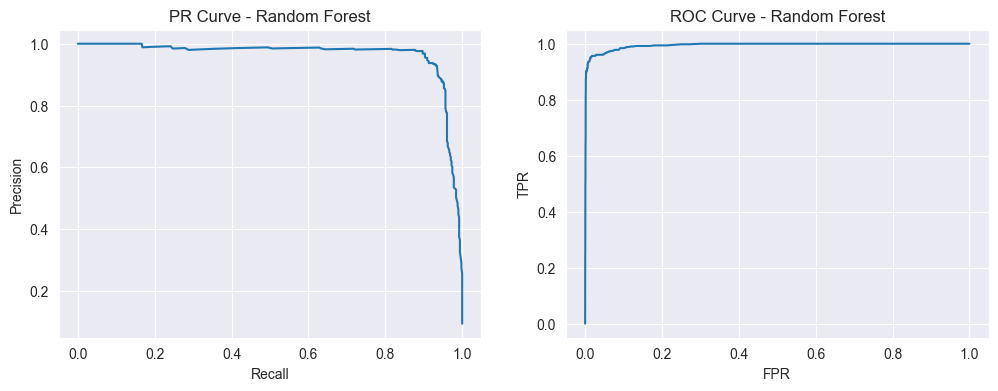

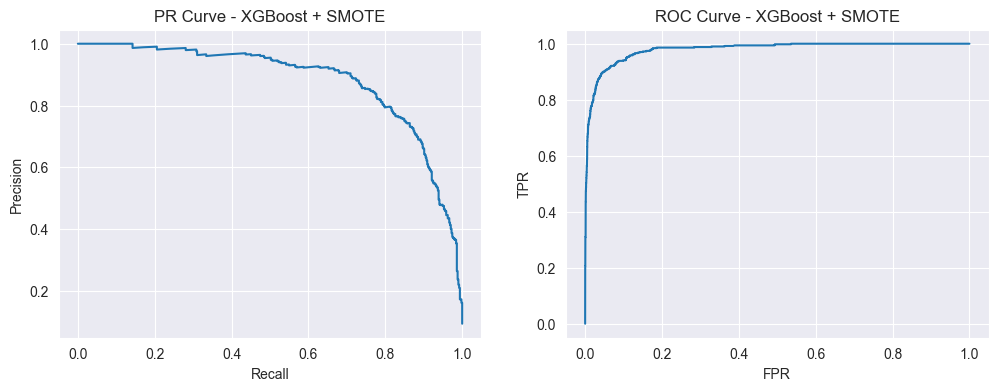

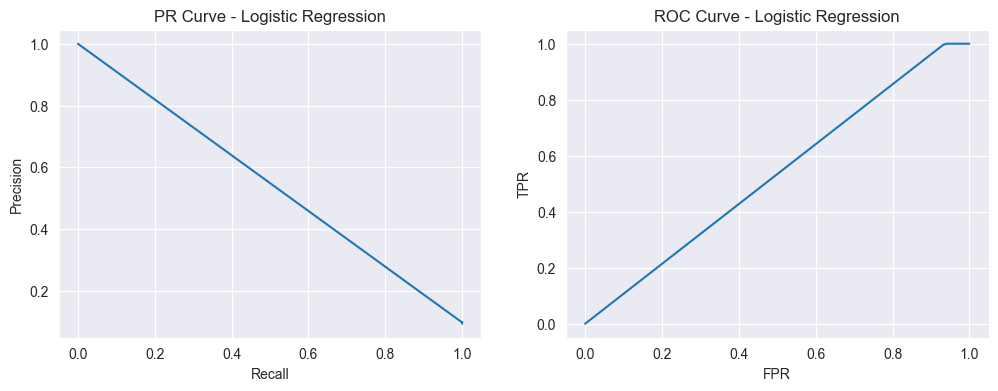

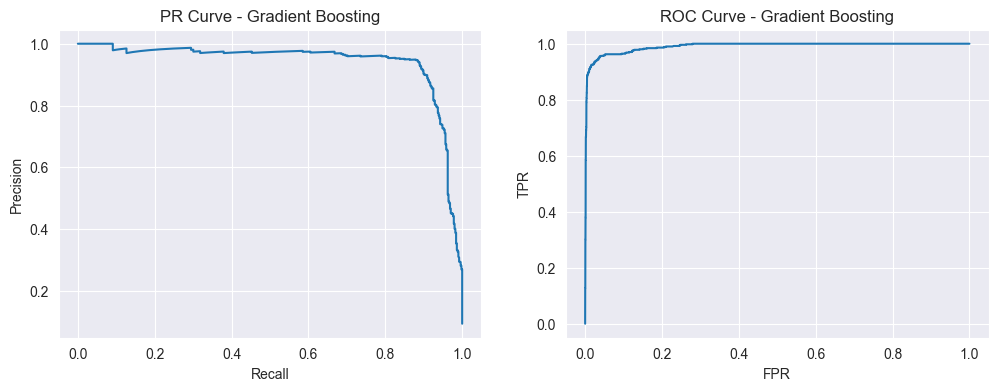

In [23]:
# ================================
# 3) Evaluate all models
# ================================
rf_probs, rf_preds = evaluate(rf, X_test, y_test, "Random Forest")
xgb_probs, xgb_preds = evaluate(smote_pipeline, X_test, y_test, "XGBoost + SMOTE")
log_probs, log_preds = evaluate(logreg, X_test, y_test, "Logistic Regression")
gb_probs, gb_preds = evaluate(gb, X_test, y_test, "Gradient Boosting")

plot_curves(y_test, rf_probs, "Random Forest")
plot_curves(y_test, xgb_probs, "XGBoost + SMOTE")
plot_curves(y_test, log_probs, "Logistic Regression")
plot_curves(y_test, gb_probs, "Gradient Boosting")

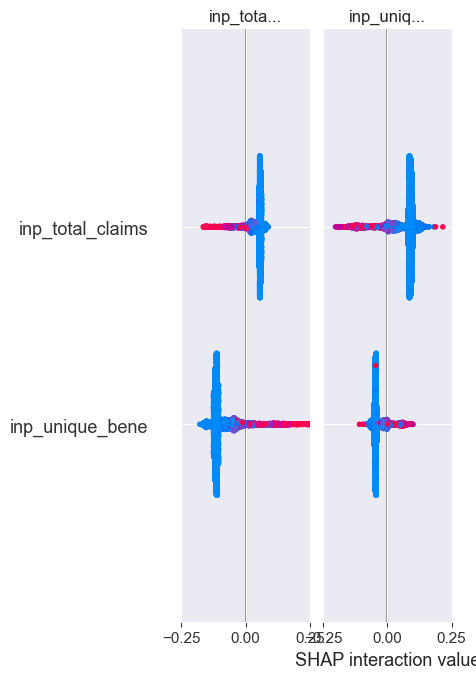

In [24]:
# ================================
# 4) SHAP Analysis (Random Forest)
# ================================
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values
shap.summary_plot(shap_class1, X_test)

In [26]:
# ================================
# 5) Error Analysis (Random Forest)
# ================================
# Make sure y_true is numeric like RF_pred
y_true_numeric = y_test.map({'No': 0, 'Yes': 1})

test_df = master.copy()
test_df["RF_pred"] = rf_preds
test_df["y_true"] = y_true_numeric.values  # use numeric labels

# False Positives (pred=1, true=0) and False Negatives (pred=0, true=1)
FP_rf = test_df[(test_df.y_true==0) & (test_df.RF_pred==1)].head(3)
FN_rf = test_df[(test_df.y_true==1) & (test_df.RF_pred==0)].head(3)

display(FP_rf)
display(FN_rf)


,Provider,PotentialFraud,inp_total_claims,inp_unique_bene,inp_sum_InscClaimAmtReimbursed,inp_mean_InscClaimAmtReimbursed,inp_sum_DeductibleAmtPaid,inp_mean_DeductibleAmtPaid,out_total_claims,out_unique_bene,out_sum_InscClaimAmtReimbursed,out_mean_InscClaimAmtReimbursed,out_sum_DeductibleAmtPaid,out_mean_DeductibleAmtPaid,RF_pred,y_true
269,PRV51342,No,28.0,28.0,319000.0,11392.857143,28836.0,1068.0,179.0,154.0,37780.0,211.061453,530.0,2.960894,1,0
361,PRV51456,No,112.0,103.0,1036690.0,9256.160714,117480.0,1068.0,23.0,21.0,2300.0,100.000000,0.0,0.000000,1,0
852,PRV52063,No,88.0,73.0,919000.0,10443.181818,91848.0,1068.0,704.0,655.0,197210.0,280.127841,1640.0,2.329545,1,0


,Provider,PotentialFraud,inp_total_claims,inp_unique_bene,inp_sum_InscClaimAmtReimbursed,inp_mean_InscClaimAmtReimbursed,inp_sum_DeductibleAmtPaid,inp_mean_DeductibleAmtPaid,out_total_claims,out_unique_bene,out_sum_InscClaimAmtReimbursed,out_mean_InscClaimAmtReimbursed,out_sum_DeductibleAmtPaid,out_mean_DeductibleAmtPaid,RF_pred,y_true
3,PRV51005,Yes,0.0,0.0,0.0,0.0,0.0,0.0,1165.0,495.0,280910.0,241.124464,3700.0,3.175966,0,1
44,PRV51059,Yes,25.0,23.0,401000.0,16040.0,26700.0,1068.0,71.0,60.0,20060.0,282.535211,240.0,3.380282,0,1
96,PRV51126,Yes,20.0,14.0,177000.0,8850.0,21360.0,1068.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1
